#### Evaluating doc2vec vectors for wiki10 documents (wikipedia article text with multiple class labels)

In [1]:
# import modules & set up logging
from pathlib import Path
import re
import string 
from itertools import islice
import multiprocessing
import json
import numpy as np
import pandas as pd 
from sklearn.manifold import TSNE
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from gensim.models import Doc2Vec

init_notebook_mode(connected=True)

In [2]:
DATA_DIR = Path('../../data/wiki10')
TEXT_DIR = DATA_DIR / 'text' 
TAGS_PATH = DATA_DIR / 'tags.json'
MODEL_PATH = DATA_DIR / 'doc2vec.model'

#### Evaluation

We will now evaluate distance between documents by reducing dimensions with T-SNE and plotting the result. We can also get an idea of how these "clusters" compare to human categorisation by loading our document labels and overlaying.

Loading model and meta data containing tag information

In [3]:
model = Doc2Vec.load(str(MODEL_PATH))

In [4]:
with TAGS_PATH.open() as input_fileobj:
    tags = json.load(input_fileobj) 

Create DataFrame from meta dictionary containing

* id: document filename
* title: wikipedia document title
* user_count: number of people which tagged the document
* tags: dict of {'tag': tag_score} where tag score is the proportion of users which assigned that tag
* mapped_tag: mapped_tag created in 01_cluster_rags

In [5]:
meta_records = [tags[doc_id] for doc_id in model.docvecs.offset2doctag]

In [9]:
meta_df = pd.DataFrame.from_records(meta_records)

In [10]:
meta_df.head()

,mapped_tag,tags,title,user_count
0,NA,"{'food': 0.4, 'culture': 0.06666666666666667}",Miso soup,15
1,religion,"{'religion': 0.23076923076923078, 'english': 0...",Eucharist,13
2,religion,"{'religion': 0.25, 'literature': 0.0625}",Book of Job,16
3,language,{'language': 0.5},Hungarian language,18
4,media,{'tv': 0.4},Undeclared,10


We still have too many classes and observations to visualize effectively so we will sample each of our classes and split them into two groups, then run TSNE/plot. 

In [11]:
meta_df = (meta_df.loc[meta_df.mapped_tag != 'NA'] 
                  .reset_index()
                  .groupby('mapped_tag') 
                  .apply(lambda x: x.sample(300)))

In [12]:
doc_vectors = model.docvecs.doctag_syn0[meta_df['index'].values]

In [13]:
meta_df.mapped_tag.value_counts()

religion       300
economics      300
art            300
music          300
math           300
science        300
film           300
people         300
politics       300
history        300
media          300
programming    300
technology     300
philosophy     300
literature     300
game           300
language       300
Name: mapped_tag, dtype: int64

In [45]:
group_1 = {'religion', 'economics', 'art', 'music', 'math', 'science', 'film', 'people', 'language'}
group_2 = {'politics', 'history', 'media', 'programming', 'technology', 'philosophy', 'literature', 'game'}

In [52]:
def plot_tsne(df, doc_vectors, tags):
    
    # filter inputs by tag type
    df.reset_index(drop=True, inplace=True)
    df = df.loc[df.mapped_tag.isin(tags)]
    doc_vectors = doc_vectors[df.index.values]
    
    # compute TSNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(doc_vectors)

    # plot results
    traces = []
    for tag_type in tags:
        trace = go.Scatter(
            x=tsne_results[df.mapped_tag==tag_type,0],
            y=tsne_results[df.mapped_tag==tag_type,1],
            mode='markers',
            name=tag_type, 
            marker=dict(
                size=5,
                opacity=0.5
            )
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    py.image.ishow(fig)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.017s...
[t-SNE] Computed neighbors for 2700 samples in 3.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 1.491933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.125298
[t-SNE] Error after 300 iterations: 1.702249


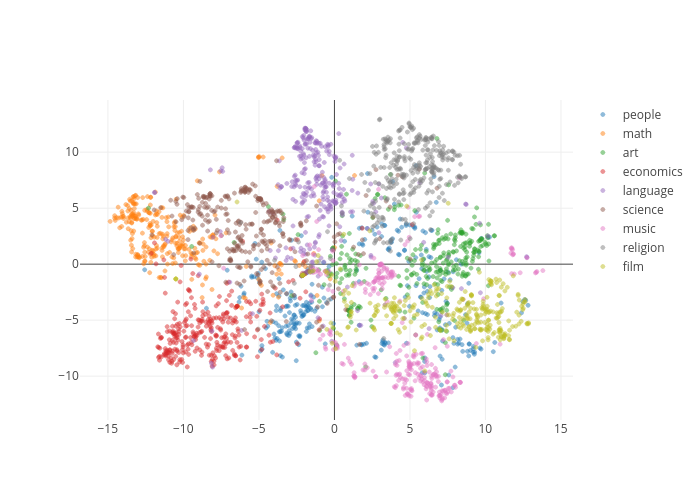

CPU times: user 54.8 s, sys: 1.5 s, total: 56.3 s
Wall time: 59.9 s


In [53]:
%%time
plot_tsne(meta_df, doc_vectors, group_1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.015s...
[t-SNE] Computed neighbors for 2400 samples in 2.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 1.467011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.378883
[t-SNE] Error after 300 iterations: 1.691491


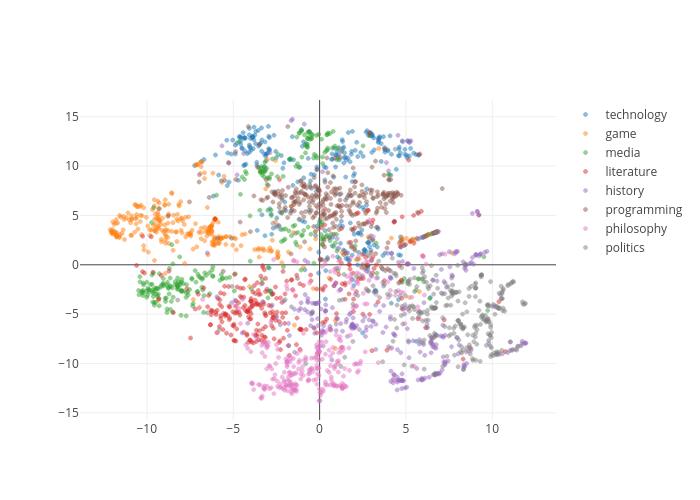

CPU times: user 40.5 s, sys: 1.35 s, total: 41.9 s
Wall time: 46.4 s


In [54]:
%%time
plot_tsne(meta_df, doc_vectors, group_2)

Even in 2 dimensions there is a clear separation between some manually labelled classes from the unsupervised doc2vec. The next step will be to try applying clustering on the document vectors to try and define new classes from scratch, and see how they compare with the manually labelled ones.